In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 12-16-18.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30  
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 12-16-18_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_03-2.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752192839.593113 23264046 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1752192839.607008 23264901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752192839.615689 23264902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1752192845.706023 23264899 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 5924
Frames with at least 1 hand detected: 5324
Detection rate: 89.87%


In [9]:
df = pd.read_csv("hand_landmarks_03-2.csv")

print("Shape:", df.shape)
df

Shape: (187761, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.000000,Left,0,NaN,NaN,NaN,0
1,0,0.000000,Left,1,NaN,NaN,NaN,0
2,0,0.000000,Left,2,NaN,NaN,NaN,0
3,0,0.000000,Left,3,NaN,NaN,NaN,0
4,0,0.000000,Left,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
187756,5923,98.733333,Right,16,NaN,NaN,NaN,0
187757,5923,98.733333,Right,17,NaN,NaN,NaN,0
187758,5923,98.733333,Right,18,NaN,NaN,NaN,0
187759,5923,98.733333,Right,19,NaN,NaN,NaN,0


In [12]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [15]:
df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,5,0.083333,Left,1,0.450122,0.453940,0.468934,0.484429,0.497593,0.474614,...,-0.002920,-0.003944,-0.004338,-0.007694,-0.007522,-0.006671,-0.010631,-0.012321,-0.010514,-0.008475
1,6,0.100000,Left,1,0.451735,0.456347,0.471441,0.487579,0.500589,0.479665,...,-0.009377,-0.009850,-0.005584,-0.012179,-0.012598,-0.010827,-0.010237,-0.014821,-0.013894,-0.011474
2,7,0.116667,Left,1,0.451016,0.455861,0.472187,0.489088,0.502560,0.478647,...,-0.008553,-0.009158,-0.004475,-0.011394,-0.012435,-0.010889,-0.009412,-0.014144,-0.013607,-0.011361
3,8,0.133333,Left,1,0.450568,0.454745,0.470890,0.487555,0.500583,0.476836,...,-0.006477,-0.007203,-0.004528,-0.009780,-0.009778,-0.008413,-0.009494,-0.013220,-0.012142,-0.010030
4,9,0.150000,Left,1,0.451314,0.455662,0.470648,0.485823,0.498381,0.477066,...,-0.007930,-0.008560,-0.005623,-0.011459,-0.011297,-0.009626,-0.011032,-0.015210,-0.014083,-0.011833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7375,5743,95.716667,Right,1,0.267794,0.326817,0.374192,0.416815,0.450945,0.279842,...,-0.113948,-0.114626,-0.039212,-0.071272,-0.079947,-0.079617,-0.012040,-0.042119,-0.054151,-0.055947
7376,5744,95.733333,Right,1,0.256097,0.272033,0.299638,0.343238,0.378946,0.186936,...,-0.200109,-0.215867,-0.071718,-0.123037,-0.149353,-0.161648,-0.041891,-0.084924,-0.110009,-0.122729
7377,5745,95.750000,Right,1,0.263146,0.266524,0.287395,0.339262,0.382907,0.180710,...,-0.156487,-0.166634,-0.055438,-0.105029,-0.121244,-0.122828,-0.040844,-0.081958,-0.097508,-0.100409
7378,5746,95.766667,Right,1,0.197237,0.188226,0.187583,0.222159,0.262203,0.101231,...,-0.130325,-0.149085,-0.038543,-0.081867,-0.103847,-0.111968,-0.028800,-0.066475,-0.079839,-0.081583


In [18]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,5,0.083,Left,1,0.450122,0.453940,0.468934,0.484429,0.497593,0.474614,...,-0.002920,-0.003944,-0.004338,-0.007694,-0.007522,-0.006671,-0.010631,-0.012321,-0.010514,-0.008475
1,6,0.100,Left,1,0.451735,0.456347,0.471441,0.487579,0.500589,0.479665,...,-0.009377,-0.009850,-0.005584,-0.012179,-0.012598,-0.010827,-0.010237,-0.014821,-0.013894,-0.011474
2,7,0.117,Left,1,0.451016,0.455861,0.472187,0.489088,0.502560,0.478647,...,-0.008553,-0.009158,-0.004475,-0.011394,-0.012435,-0.010889,-0.009412,-0.014144,-0.013607,-0.011361
3,8,0.133,Left,1,0.450568,0.454745,0.470890,0.487555,0.500583,0.476836,...,-0.006477,-0.007203,-0.004528,-0.009780,-0.009778,-0.008413,-0.009494,-0.013220,-0.012142,-0.010030
4,9,0.150,Left,1,0.451314,0.455662,0.470648,0.485823,0.498381,0.477066,...,-0.007930,-0.008560,-0.005623,-0.011459,-0.011297,-0.009626,-0.011032,-0.015210,-0.014083,-0.011833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7375,5743,95.717,Right,1,0.267794,0.326817,0.374192,0.416815,0.450945,0.279842,...,-0.113948,-0.114626,-0.039212,-0.071272,-0.079947,-0.079617,-0.012040,-0.042119,-0.054151,-0.055947
7376,5744,95.733,Right,1,0.256097,0.272033,0.299638,0.343238,0.378946,0.186936,...,-0.200109,-0.215867,-0.071718,-0.123037,-0.149353,-0.161648,-0.041891,-0.084924,-0.110009,-0.122729
7377,5745,95.750,Right,1,0.263146,0.266524,0.287395,0.339262,0.382907,0.180710,...,-0.156487,-0.166634,-0.055438,-0.105029,-0.121244,-0.122828,-0.040844,-0.081958,-0.097508,-0.100409
7378,5746,95.767,Right,1,0.197237,0.188226,0.187583,0.222159,0.262203,0.101231,...,-0.130325,-0.149085,-0.038543,-0.081867,-0.103847,-0.111968,-0.028800,-0.066475,-0.079839,-0.081583


In [21]:
df2 = pd.read_csv("hand_lable_03-2.csv")

print("Shape:", df.shape)
df2

Shape: (187761, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,03-2,2025-07-07 21:46:30.898,NaN,82.216,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,98.733,60.0,NaN,lift,NaN,START,16.517,D:/Data Science/UOB/DS_project/Full Study/03-2...,991,NaN,NaN
1,03-2,2025-07-07 21:46:30.898,NaN,82.216,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,98.733,60.0,NaN,lift,NaN,STOP,17.050,D:/Data Science/UOB/DS_project/Full Study/03-2...,1023,NaN,NaN
2,03-2,2025-07-07 21:46:30.898,NaN,82.216,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,98.733,60.0,NaN,press,NaN,START,17.067,D:/Data Science/UOB/DS_project/Full Study/03-2...,1024,NaN,NaN
3,03-2,2025-07-07 21:46:30.898,NaN,82.216,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,98.733,60.0,NaN,press,NaN,STOP,17.400,D:/Data Science/UOB/DS_project/Full Study/03-2...,1044,NaN,NaN
4,03-2,2025-07-07 21:46:30.898,NaN,82.216,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,98.733,60.0,NaN,hold,NaN,START,17.417,D:/Data Science/UOB/DS_project/Full Study/03-2...,1045,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,03-2,2025-07-07 21:46:30.898,NaN,82.216,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,98.733,60.0,NaN,press,NaN,STOP,90.633,D:/Data Science/UOB/DS_project/Full Study/03-2...,5438,NaN,NaN
122,03-2,2025-07-07 21:46:30.898,NaN,82.216,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,98.733,60.0,NaN,place,NaN,START,90.650,D:/Data Science/UOB/DS_project/Full Study/03-2...,5439,NaN,NaN
123,03-2,2025-07-07 21:46:30.898,NaN,82.216,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,98.733,60.0,NaN,place,NaN,STOP,91.733,D:/Data Science/UOB/DS_project/Full Study/03-2...,5504,NaN,NaN
124,03-2,2025-07-07 21:46:30.898,NaN,82.216,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,98.733,60.0,NaN,other,NaN,START,91.750,D:/Data Science/UOB/DS_project/Full Study/03-2...,5505,NaN,NaN


In [24]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,lift,16.517,17.050,991,1023
1,press,17.067,17.400,1024,1044
2,hold,17.417,17.700,1045,1062
3,press,17.717,18.133,1063,1088
4,rotate,18.150,20.333,1089,1220
...,...,...,...,...,...
58,rotate,85.633,89.400,5138,5364
59,hold,89.417,90.267,5365,5416
60,press,90.283,90.633,5417,5438
61,place,90.650,91.733,5439,5504


In [27]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_7290/1143471531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'lift' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,5,0.083,Left,1,0.450122,0.453940,0.468934,0.484429,0.497593,0.474614,...,-0.003944,-0.004338,-0.007694,-0.007522,-0.006671,-0.010631,-0.012321,-0.010514,-0.008475,NaN
1,6,0.100,Left,1,0.451735,0.456347,0.471441,0.487579,0.500589,0.479665,...,-0.009850,-0.005584,-0.012179,-0.012598,-0.010827,-0.010237,-0.014821,-0.013894,-0.011474,NaN
2,7,0.117,Left,1,0.451016,0.455861,0.472187,0.489088,0.502560,0.478647,...,-0.009158,-0.004475,-0.011394,-0.012435,-0.010889,-0.009412,-0.014144,-0.013607,-0.011361,NaN
3,8,0.133,Left,1,0.450568,0.454745,0.470890,0.487555,0.500583,0.476836,...,-0.007203,-0.004528,-0.009780,-0.009778,-0.008413,-0.009494,-0.013220,-0.012142,-0.010030,NaN
4,9,0.150,Left,1,0.451314,0.455662,0.470648,0.485823,0.498381,0.477066,...,-0.008560,-0.005623,-0.011459,-0.011297,-0.009626,-0.011032,-0.015210,-0.014083,-0.011833,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7375,5743,95.717,Right,1,0.267794,0.326817,0.374192,0.416815,0.450945,0.279842,...,-0.114626,-0.039212,-0.071272,-0.079947,-0.079617,-0.012040,-0.042119,-0.054151,-0.055947,other
7376,5744,95.733,Right,1,0.256097,0.272033,0.299638,0.343238,0.378946,0.186936,...,-0.215867,-0.071718,-0.123037,-0.149353,-0.161648,-0.041891,-0.084924,-0.110009,-0.122729,other
7377,5745,95.750,Right,1,0.263146,0.266524,0.287395,0.339262,0.382907,0.180710,...,-0.166634,-0.055438,-0.105029,-0.121244,-0.122828,-0.040844,-0.081958,-0.097508,-0.100409,other
7378,5746,95.767,Right,1,0.197237,0.188226,0.187583,0.222159,0.262203,0.101231,...,-0.149085,-0.038543,-0.081867,-0.103847,-0.111968,-0.028800,-0.066475,-0.079839,-0.081583,other


In [30]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
rotate    3513
NaN       1295
adjust     922
other      493
press      402
hold       402
place      253
lift       100
Name: count, dtype: int64


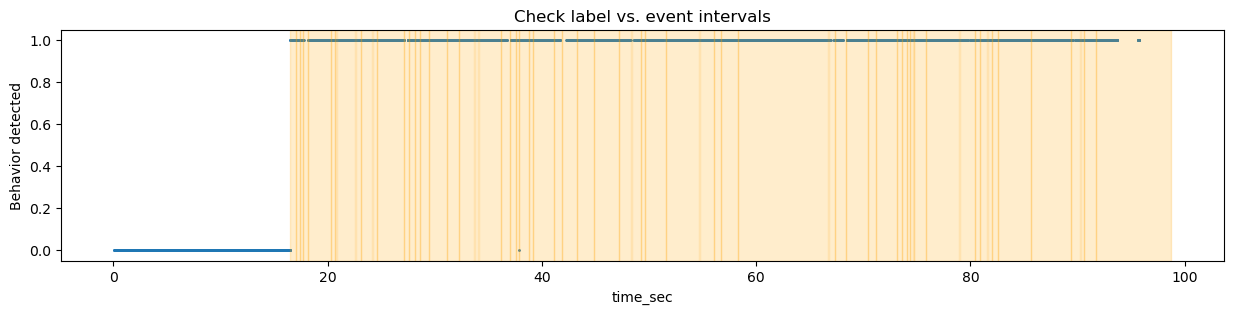

In [33]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [40]:
df_clean = df_wide.dropna(subset=['behavior'])

df_wide = df_clean

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
1294,991,16.517,Left,1,0.668196,0.645471,0.628260,0.605856,0.581616,0.658936,...,0.072730,0.065735,0.090308,0.090290,0.086558,0.078789,0.098791,0.103242,0.104367,lift
1295,992,16.533,Left,1,0.667761,0.643050,0.625085,0.603795,0.581072,0.667490,...,0.049755,0.056802,0.075158,0.071739,0.066091,0.071618,0.085079,0.085792,0.084792,lift
1296,993,16.550,Left,1,0.652958,0.633827,0.619887,0.601123,0.579243,0.669859,...,0.066900,0.057640,0.081455,0.082661,0.079243,0.072492,0.090945,0.095623,0.096672,lift
1297,994,16.567,Left,1,0.660066,0.634832,0.617379,0.600397,0.580233,0.672634,...,0.035876,0.036184,0.048416,0.052997,0.054415,0.045755,0.055097,0.061520,0.065798,lift
1298,995,16.583,Left,1,0.648947,0.624184,0.609870,0.595577,0.582001,0.667831,...,-0.000289,0.017563,0.019782,0.018466,0.016933,0.027734,0.028201,0.028196,0.028366,lift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7375,5743,95.717,Right,1,0.267794,0.326817,0.374192,0.416815,0.450945,0.279842,...,-0.114626,-0.039212,-0.071272,-0.079947,-0.079617,-0.012040,-0.042119,-0.054151,-0.055947,other
7376,5744,95.733,Right,1,0.256097,0.272033,0.299638,0.343238,0.378946,0.186936,...,-0.215867,-0.071718,-0.123037,-0.149353,-0.161648,-0.041891,-0.084924,-0.110009,-0.122729,other
7377,5745,95.750,Right,1,0.263146,0.266524,0.287395,0.339262,0.382907,0.180710,...,-0.166634,-0.055438,-0.105029,-0.121244,-0.122828,-0.040844,-0.081958,-0.097508,-0.100409,other
7378,5746,95.767,Right,1,0.197237,0.188226,0.187583,0.222159,0.262203,0.101231,...,-0.149085,-0.038543,-0.081867,-0.103847,-0.111968,-0.028800,-0.066475,-0.079839,-0.081583,other


In [45]:
df_wide['dataset_id'] = '0302'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
1294,0302,991,16.517,Left,1,0.668196,0.645471,0.628260,0.605856,0.581616,...,0.072730,0.065735,0.090308,0.090290,0.086558,0.078789,0.098791,0.103242,0.104367,lift
1295,0302,992,16.533,Left,1,0.667761,0.643050,0.625085,0.603795,0.581072,...,0.049755,0.056802,0.075158,0.071739,0.066091,0.071618,0.085079,0.085792,0.084792,lift
1296,0302,993,16.550,Left,1,0.652958,0.633827,0.619887,0.601123,0.579243,...,0.066900,0.057640,0.081455,0.082661,0.079243,0.072492,0.090945,0.095623,0.096672,lift
1297,0302,994,16.567,Left,1,0.660066,0.634832,0.617379,0.600397,0.580233,...,0.035876,0.036184,0.048416,0.052997,0.054415,0.045755,0.055097,0.061520,0.065798,lift
1298,0302,995,16.583,Left,1,0.648947,0.624184,0.609870,0.595577,0.582001,...,-0.000289,0.017563,0.019782,0.018466,0.016933,0.027734,0.028201,0.028196,0.028366,lift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7375,0302,5743,95.717,Right,1,0.267794,0.326817,0.374192,0.416815,0.450945,...,-0.114626,-0.039212,-0.071272,-0.079947,-0.079617,-0.012040,-0.042119,-0.054151,-0.055947,other
7376,0302,5744,95.733,Right,1,0.256097,0.272033,0.299638,0.343238,0.378946,...,-0.215867,-0.071718,-0.123037,-0.149353,-0.161648,-0.041891,-0.084924,-0.110009,-0.122729,other
7377,0302,5745,95.750,Right,1,0.263146,0.266524,0.287395,0.339262,0.382907,...,-0.166634,-0.055438,-0.105029,-0.121244,-0.122828,-0.040844,-0.081958,-0.097508,-0.100409,other
7378,0302,5746,95.767,Right,1,0.197237,0.188226,0.187583,0.222159,0.262203,...,-0.149085,-0.038543,-0.081867,-0.103847,-0.111968,-0.028800,-0.066475,-0.079839,-0.081583,other


In [48]:
df_wide.to_csv("handlandmark_wide_03-2.csv", index=False)